# Regression with neural networks

This notebook contains some code snippets for regression using neural networks. Each snippet should run in at most a
few seconds. The purpose of this demo is to see what effect different parameters and topologies of the neural network
have on
- The quality of the fit
- Overfitting
- Vanishing gradient problem

We will use the multilayer perceptron of scikit-learn. Please consult its documentation 
[here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)
when changing parameters


### Other resources on scikit-learn are

[On overfitting in linear regression](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)

[On regularization neural networks](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html)


## Tasks

Below we will train the neural network to fit a noisy sine function using two different setups. The sine function has a
certain phase, number of cycles and noise amplitude. The function, and the tasks are defined further down in the notebook.

The setups are:
- **(1)** Use MLP (NN) with a single input neuron being $x$ and the output/target being $f(x)$.
- **(2)** Use MLP (NN) with 32 input neurons being values of $f(x_i)$ for $x_i$ in `np.linspace(0,1,32)` and the
  target/output being the phase of $f(x)$. This determines the solution of inverse problem (determine phase based
  on the given grid values).

# Necessary imports and definition of our function

Here we define and plot our noisy sine function

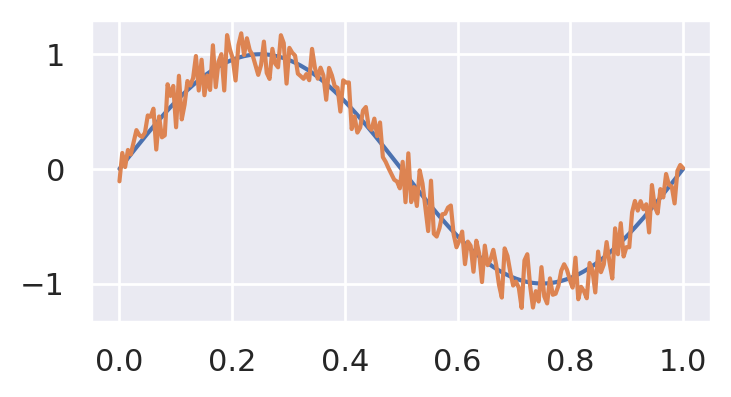

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
import numpy as np
import seaborn as sns
sns.set_context("paper", font_scale=1.5)
sns.set_style("darkgrid")
sns.set_palette("deep")
sns.set(font='sans-serif')


def func(x, noise_amplitude=0.0, number_of_cycles=1.0, phase=0.0):
    data = np.sin(2*np.pi*(x+phase)*number_of_cycles)
    noise = np.random.uniform(-noise_amplitude/2, noise_amplitude/2, size=x.shape)
    
    return data + noise


# For convenience you might or might not want to plot it
do_plot = True
if do_plot:
    x = np.linspace(0, 1, 200)
    plt.figure(figsize=(4,2))
    plt.plot(x, func(x))
    plt.plot(x, func(x, noise_amplitude=0.5))

## Helper functions to visualize the training of setup **(1)**

Define the following helper functions

In [2]:
def describe_topology(mlpr, verbose=False):
    w = []
    w.append('Perceptron topology:')
    w.append(f'  {"Input layer":20} - {mlpr.n_features_in_} neurons')
    hls = mlpr.hidden_layer_sizes
    if not isinstance(hls, tuple):
        hls = (hls, )
    for i, size in enumerate(hls):
        w.append(f'  {f"Hidden layer {i+1}":20} - {size} neurons  ')
    w.append(f'  {"Output layer":20} - {mlpr.n_outputs_} neurons')
    
    if verbose:
        print('\n'.join(w))
        
    return w

def train_test_score(mlpr, X_train, Y_train, X_test, Y_test, verbose=False):
    w = []
    train_s = mlpr.score(X_train, Y_train)
    test_s = mlpr.score(X_test, Y_test)
    w.append(f'{"Train score":20} {train_s:.5f}')
    w.append(f'{"Test score":20} {test_s:.5f}')
    
    if verbose:
        print('\n'.join(w))
        
    return w

def visualize_setup_1(mlpr, X_train, Y_train, X_test, Y_test):
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    
    ax = axes[0]
    ax.plot(mlpr.loss_curve_)
    text = '\n'.join(describe_topology(mlpr, verbose=False) +
                     train_test_score(mlpr, X_train, Y_train, X_test, Y_test, verbose=False))
    ax.text(0.28, 0.98, text,
            fontsize=8, ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    
    ax = axes[1]
    x = np.linspace(0, 1, 200)
    y = mlpr.predict(x.reshape((-1, 1)))

    ax.plot(x, y, color='cornflowerblue', label='Predicted output')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax.scatter(X_train, Y_train, 2, color='goldenrod', label='Training data')
    ax.scatter(X_test, Y_test, 2, color='seagreen', label='Testing data')
    
    ax.legend()
    
    fig.tight_layout()

## Setup and train **(1)**

### The tasks here are:
- Consider setup (1) with `number_of_cycles = 0.5`, `1`, `2`, `noise_amplitude = 0`, `phi = 0`. See the necessity of hidden layers. 
- Consider setup (1) with `noise_amplitude > 0`.  See the effect of overfitting. Try holdout sets, build the learning curve. Vary the complexity of the problem , see the effect of vanishing gradients.

### Notes:
Change the parameter `hidden_layer_sizes` to set the topology of the network, for example:
```python
hidden_layer_sizes = () # No hidden layers
hidden_layer_sizes = (20,) # One layer hidden layer with 20 neurons
hidden_layer_sizes = (20, 10) # Two hidden layers with 20 and 10 neurons respectively
```

Keep in mind that the training is stochastic. Try re-running the same code a few times and see if the outcome changes.

A tightened tolerance `tol=1e-9` and time without change `n_iter_no_change=100` might be necessary to not get stuck in local mimima

Stopped after 196 iterations with loss function 0.05946


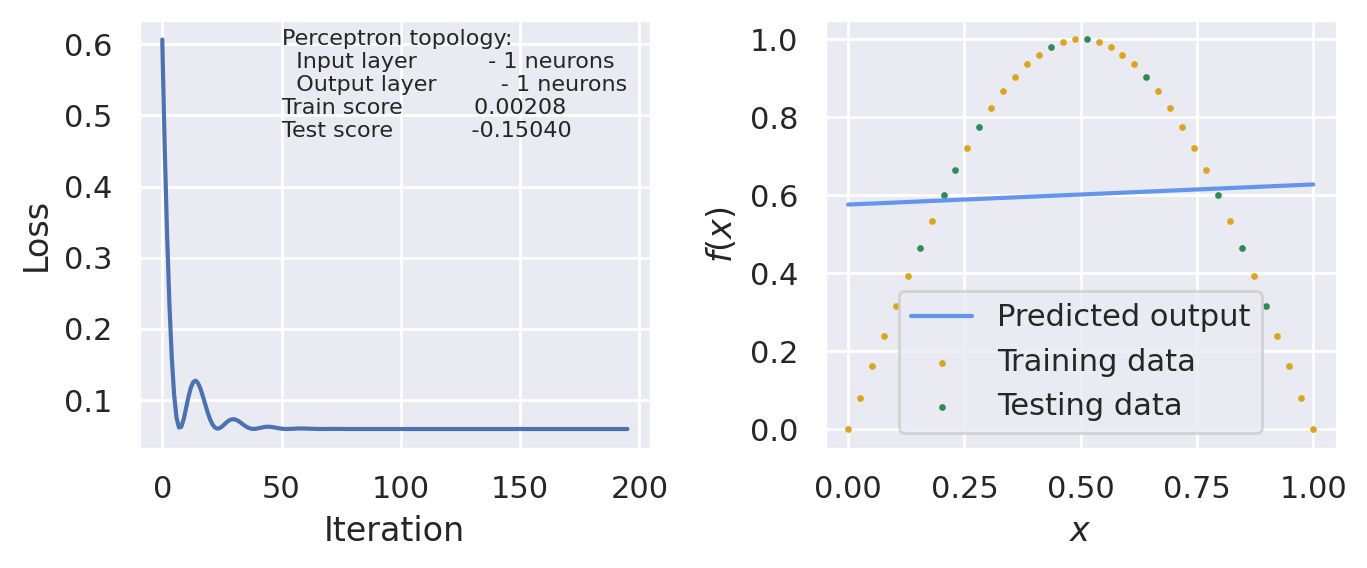

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

hidden_layer_sizes = ()
reg_1 = MLPRegressor(hidden_layer_sizes, solver='adam', activation='tanh',
                     tol=1e-9, n_iter_no_change=50, max_iter=5000,
                     alpha=0.0, momentum=0.9, learning_rate_init=0.1)

x = np.linspace(0, 1, 40)
X = x.reshape((-1, 1))
Y = func(x, number_of_cycles=0.5, noise_amplitude=0.0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75) # Split off 25% of data for test

reg_1.fit(X_train, Y_train)
print(f'Stopped after {reg_1.n_iter_} iterations with loss function {reg_1.loss_:.5f}')

visualize_setup_1(reg_1, X_train, Y_train, X_test, Y_test)

## Helper function to visualize the trained setup **(2)**

The following helper function can be useful to visualize setup **(2)**

In [4]:
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap, ScalarMappable

def visualize_setup_2(mlpr, X_train, Y_train, X_test, Y_test):
    fig, axes = plt.subplots(3, 1, figsize=(7, 6))
    norm = Normalize(0, 1)
    cmap = get_cmap('viridis')
    
    ax = axes[0]
    ax.plot(mlpr.loss_curve_)
    
    text = '\n'.join(describe_topology(mlpr, verbose=False) +
                     train_test_score(mlpr, X_train, Y_train, X_test, Y_test, verbose=False))
    ax.text(0.28, 0.98, text,
            fontsize=8, ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    
    for ax, X, Y in zip(axes[1:], (X_train, X_test), (Y_train, Y_test)):
        x = np.linspace(0, 1, X.shape[1])
        for i in range(X.shape[0]):
            color = cmap(norm(Y[i]))
            ax.plot(x, X[i, :], color=color, alpha=0.3)

        ax.set_xlabel('$x$')
        ax.set_ylabel('$f(x)$')
        cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
        cbar.set_label('Phase')
    axes[1].set_title('Training data')
    axes[2].set_title('Testing data')
    
    fig.tight_layout()

## Setup and train **(2)**

### The tasks here are:
- Consider setup **(2)**. Explain, why this is easier to fit than **(1)**. Play with parameters.
  - (Optionally: build the fixed first layer of Nk = 2, 4, 8 neurons for task **(1)**: the k-th neuron fires if x in `[k/Nk, (k+1)/Nk]`; Observe better learning capabilities, discuss.)  
- Play with all the parameters, learning rate, layout of  hidden layers, etc. Discuss and try to understand the observations.

Stopped after 23 iterations with loss function 0.00162


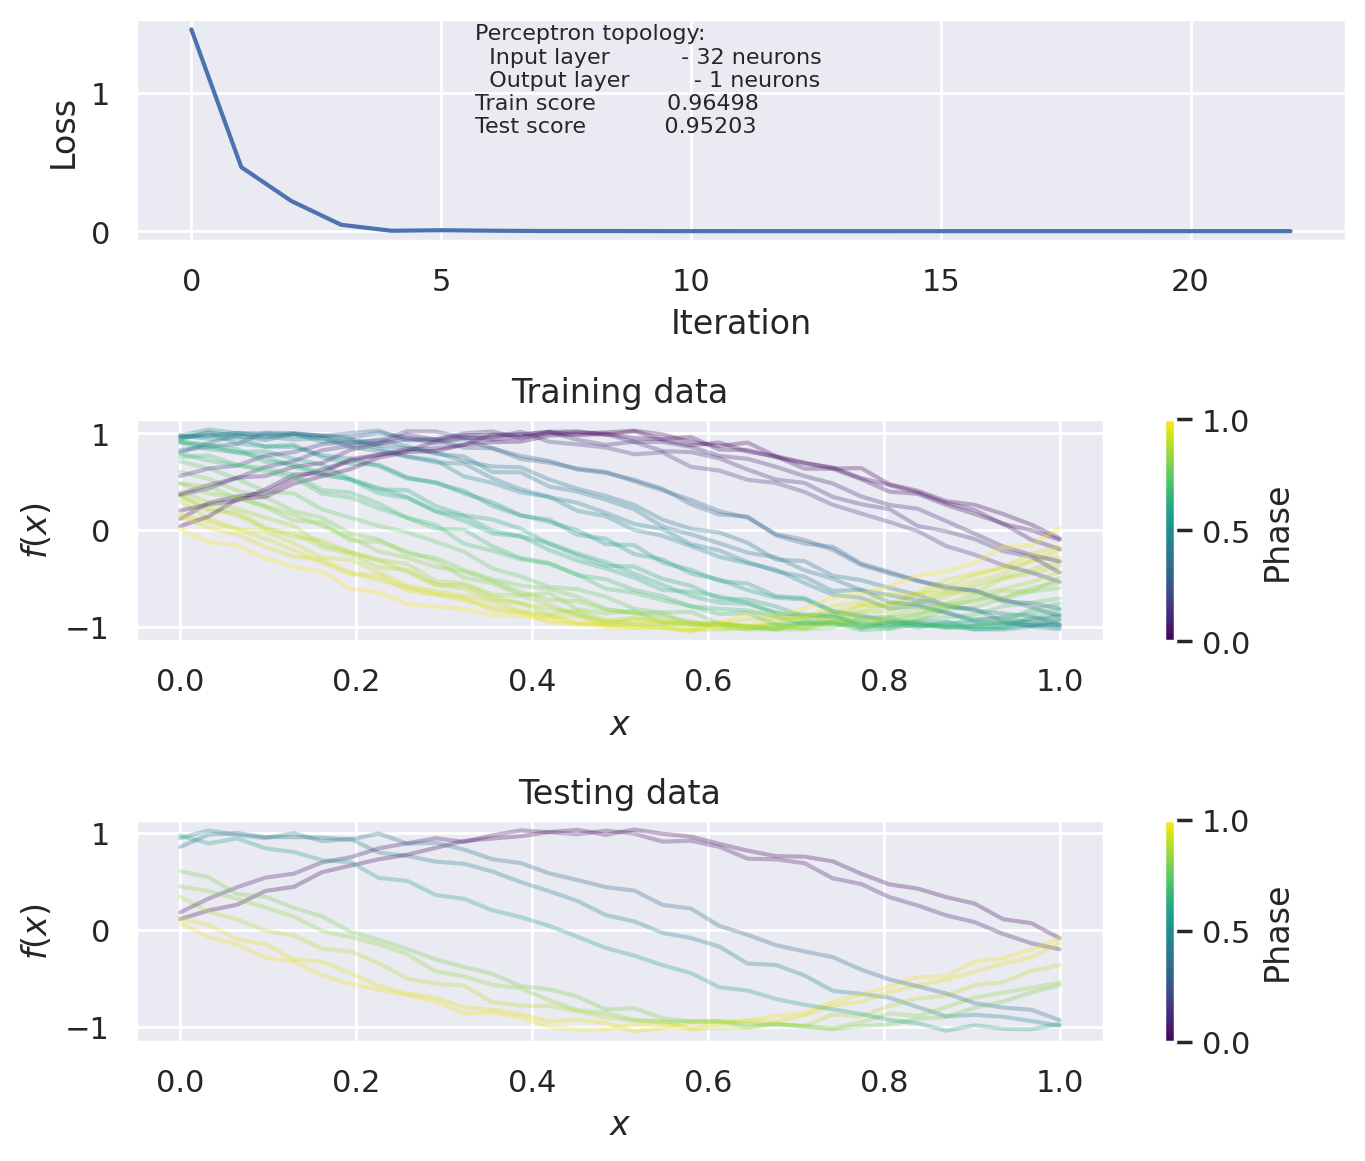

In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
hidden_layer_sizes = ()
reg_2 = MLPRegressor(hidden_layer_sizes, solver='sgd', activation='tanh',
                     tol=1e-4, n_iter_no_change=10, max_iter=5000,
                     alpha=0.0, momentum=0.9, learning_rate_init=0.1)

n_samples = 40
n_grid = 32
x = np.linspace(0, 1, n_grid)

X = np.zeros((n_samples, n_grid))
Y = np.zeros((n_samples, ))

for i in range(n_samples):
    phase = np.random.rand()
    X[i, :] = func(x, number_of_cycles=0.5, noise_amplitude=0.1, phase=phase)
    Y[i] = phase
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75) # Split off 25% of data for test

reg_2.fit(X_train, Y_train)
print(f'Stopped after {reg_2.n_iter_} iterations with loss function {reg_2.loss_:.5f}')

visualize_setup_2(reg_2, X_train, Y_train, X_test, Y_test)